<font size="18"> External Source Operator Example </font>

This application demonstrates a simple rocAL pipeline with External Source Operator supported by rocAL.

<font size="12"> Common Code </font>

In [1]:
from amd.rocal.plugin.generic import ROCALClassificationIterator
from amd.rocal.pipeline import Pipeline
import amd.rocal.fn as fn
import amd.rocal.types as types 
import cv2
import cupy as cp
import random
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def generate_random_numbers(count):
    """Generate a list of random floating-point numbers."""
    random_numbers = []
    for _ in range(count):
        random_numbers.append(random.uniform(1.0, 1.0))  # Generates random floats between 1.0 and 100.0
    return random_numbers

In [3]:
batch_size = 5
num_threads = 1
device_id = 0
local_rank = 0
world_size = 1
rocal_cpu = True
random_seed = 0
max_height = 720
max_width = 640
color_format = types.RGB
data_path="/media/MIVisionX-data/rocal_data/coco/coco_10_img/train_10images_2017/"
decoder_device = 'cpu'

In [4]:
pipe = Pipeline(batch_size=batch_size, num_threads=num_threads, device_id=device_id, seed=random_seed, rocal_cpu=rocal_cpu, tensor_layout=types.NHWC , tensor_dtype=types.FLOAT, output_memory_type=types.HOST_MEMORY if rocal_cpu else types.DEVICE_MEMORY)

Pipeline has been created succesfully
OK: loaded 115 kernels from libvx_rpp.so


In [5]:
#Module 5
with pipe:
    jpegs, _ = fn.readers.file(file_root=data_path)
    images = fn.decoders.image(jpegs,
                                file_root=data_path,
                                device=decoder_device,
                                max_decoded_width=max_width,
                                max_decoded_height=max_height,
                                output_type=color_format,
                                shard_id=local_rank,
                                num_shards=world_size,
                                random_shuffle=False)
    output = fn.external_source(images, source = generate_random_numbers, size=batch_size)
    contrast_output = fn.contrast(images, contrast_center=output , contrast = output)
    pipe.set_outputs(contrast_output)

In [6]:
#Module 6
pipe.build()

In [7]:
# Dataloader
data_loader = ROCALClassificationIterator(
    pipe, device="cpu", device_id=local_rank)

<font size ="12">Visualizing  outputs</font>

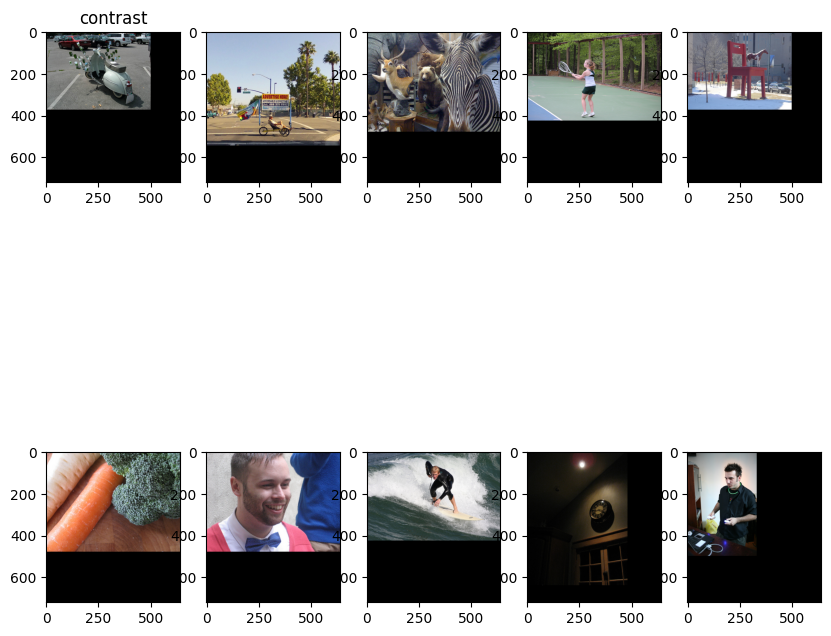

In [8]:
cnt = 0
aug_list = ["contrast"] 
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,10))
row = 0
col = 0
for i, it in enumerate(data_loader, 0):
    for img in it[0]:
        for im in img:
            if(cnt < len(aug_list)):
                axes[row, col].set_title(aug_list[cnt])
            img = (im).astype('uint8')
            axes[row, col].imshow(img)
            cnt += 1
            row += 1
            if(row == 2):
                row = 0
                col += 1
            if(col == 5):
                col = 0
data_loader.reset()